# To run this notebook locally:
* Make sure that [Jupyter](https://jupyter.org/) is installed, along with [Julia](https://www.julialang.org/) and its [Jupyter Kernel](https://github.com/JuliaLang/IJulia.jl).
* Clone or download [GpABC.jl](https://github.com/tanhevg/GpABC.jl) to your machine.
* Run `jupyter` from the `examples` directory of the local copy of `GpABC.jl`:
```bash
$ cd GpABC.jl/examples
$ jupyter notebook gp-example.ipynb
```
* The first line of the cell below activates the local project environment and downloads all the dependencies.

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve()
using GpABC, Distributions, Plots

Activating environment at `~/gaussian_processes/GpABC.jl/examples/Project.toml`
 Resolving package versions...
  Updating `~/gaussian_processes/GpABC.jl/examples/Project.toml`
 [no changes]
  Updating `~/gaussian_processes/GpABC.jl/examples/Manifest.toml`
 [no changes]


┌ Info: Precompiling GpABC [e850a1a4-d859-11e8-3d54-a195e6d045d3]
└ @ Base loading.jl:1242
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for GpABC [e850a1a4-d859-11e8-3d54-a195e6d045d3]
│   exception = ErrorException("Required dependency OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed] failed to load from a cache file.")
└ @ Base loading.jl:1025
┌ Info: Recompiling stale cache file /data/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


# Gaussian Process Regression with `GpABC`

## Setup

Define the latent function that we are going to approximate:

In [2]:
f(x) = x ^ 2 + 10 * sin(x) 

f (generic function with 1 method)

Set up some training and test data. Random noise is added to observations in training points, to make the task a little bit harder.

In [3]:
n = 30
training_x = sort(rand(Uniform(-10, 10), n))
training_y = f.(training_x)
training_y += 20 * (rand(n) .- 0.5) # add some noise
test_x = range(min(training_x...), stop=max(training_x...), length=1000) |> collect;


## Known hyperparameters

The package is built around a type `GPModel`, which encapsulates all the information
required for training the Gaussian Process and performing the regression. In the simplest
scenario the user would instantiate this type with some training data and labels, provide
the hyperparameters and run the regression. `SquaredExponentialIsoKernel` will be used by default. 

Assume we already know the kernel hyperparameters:

- $\sigma_f = 37.08$
- $l = 1.0 $
- $\sigma_n = 6.58$

In [4]:
hypers = [37.08, 1.0, 6.58];

Run the regression and plot the results

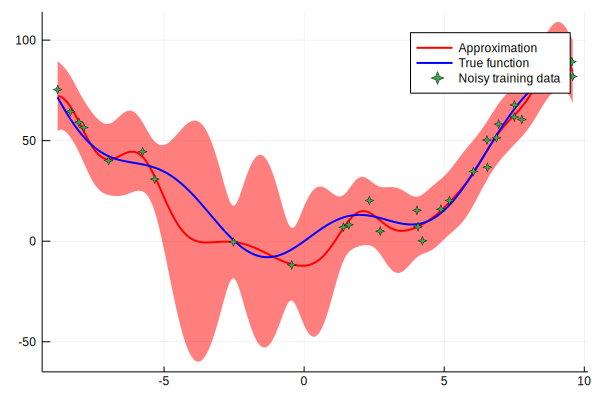

In [5]:
gpm = GPModel(training_x, training_y)
set_hyperparameters(gpm, hypers)
test_y, test_var = gp_regression(test_x, gpm)

plot(test_x, test_y, ribbon=1.96 * sqrt.(test_var), c=:red, linewidth=2, label="Approximation")
plot!(test_x, f.(test_x), c=:blue, linewidth=2, label="True function")
scatter!(training_x, training_y, m=:star4, label="Noisy training data")

## Training the hyperparameters

Normally, kernel hyperparameters are not known in advance. In this scenario the `gp_train` function should be used to find the Maximum Likelihood Estimate (MLE) of hyperparameters. By default,
[Conjugate Gradient](http://julianlsolvers.github.io/Optim.jl/stable/algo/cg/) bounded box optimisation is used, as long as the gradient
with respect to hyperparameters is implemented for the kernel function. If the gradient
implementation is not provided, [Nelder Mead](http://julianlsolvers.github.io/Optim.jl/stable/algo/nelder_mead/) optimiser is used by default.


In [6]:
gp_train(gpm)

3-element Array{Float64,1}:
 50.22608757244049 
  3.006323303024928
  5.81649511833659 

Re-run the regression with optimised hyperparameters, and plot the results

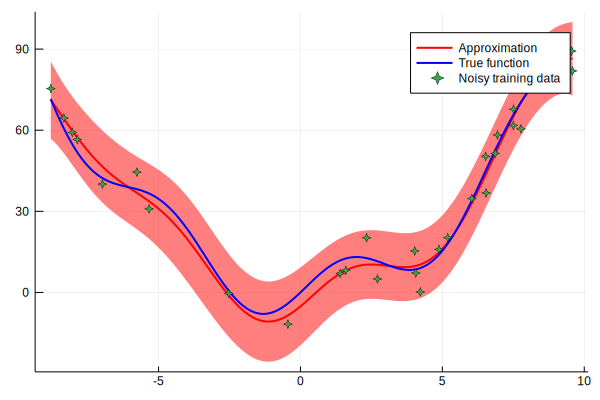

In [7]:
test_y, test_var = gp_regression(test_x, gpm)

plot(test_x, test_y, ribbon=1.96 * sqrt.(test_var), c=:red, linewidth=2, label="Approximation")
plot!(test_x, f.(test_x), c=:blue, linewidth=2, label="True function")
scatter!(training_x, training_y, m=:star4, label="Noisy training data")

## Advanced usage of `gp_train`

In [19]:
import Optim.SimulatedAnnealing
gpm = GPModel(training_x, training_y)
gp_train(gpm; optimiser=SimulatedAnnealing(), 
    hp_lower=exp.([-10.0, -1.0, -10.0]), 
    hp_upper=exp.([10.0, 2.0, 10.0]), 
    log_level=1)

Bound optimisation using SimulatedAnnealing{typeof(Optim.default_neighbor!),typeof(Optim.log_temperature)}. Gradient provided. Start point: [1.0, 1.0, 1.0]; lower bound: [-10.0, -1.0, -10.0]; upper bound: [10.0, 2.0, 10.0]
 * Status: success

 * Candidate solution
    Minimizer: [3.77e+00, 9.70e-01, 1.70e+00]
    Minimum:   1.146098e+02

 * Found with
    Algorithm:     Fminbox with Simulated Annealing
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.42e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    4
    f(x) calls:    10010
    ∇f(x) calls:   0

Optimized log hyperparameters: [3.774726219265351, 0.9695372276196905, 1.697532885208078]
Optimized hyperparameters: [43.585573791663876, 2.636723973942824,

3-element Array{Float64,1}:
 43.585573791663876
  2.636723973942824
  5.460459180471127

## Creating a cutsom kernel

Suppose we want to implement our own kernel function that adds a periodic element to the standard SE ISO kernel:
$$
k(x, x') = \sigma_f^2 \exp\left(-\frac{(x - x')^2}{2l^2}\right) + \exp(-2\sin^2(\sigma_g\pi(x - x')))
$$

This kernel introduces a new hyperparameter, $\sigma_g$, in addition to the standard hyperparameters of $\sigma_f$ and $l$.

In [9]:
import GpABC.covariance, GpABC.get_hyperparameters_size, 
GpABC.covariance_grad, GpABC.covariance_training, GpABC.covariance_diagonal

mutable struct SeIsoPeriodicKernelCache
    last_theta::AbstractArray{Float64, 1}
    D2::AbstractArray{Float64, 2} 
    D::AbstractArray{Float64, 2}
    se_part::AbstractArray{Float64, 2} 
    periodic_part::AbstractArray{Float64, 2}
end
  
SeIsoPeriodicKernelCache() = SeIsoPeriodicKernelCache(zeros(0), zeros(0, 0), zeros(0, 0), zeros(0, 0), zeros(0, 0))

struct SeIsoPeriodicKernel <: AbstractGPKernel
    cache::SeIsoPeriodicKernelCache
end
SeIsoPeriodicKernel() = SeIsoPeriodicKernel(SeIsoPeriodicKernelCache())

function get_hyperparameters_size(ker::SeIsoPeriodicKernel, training_data::AbstractArray{Float64, 2})
    3
end

function covariance(ker::SeIsoPeriodicKernel, log_theta::AbstractArray{Float64, 1}, 
        x1::AbstractArray{Float64, 2}, x2::AbstractArray{Float64, 2})
    D2 = scaled_squared_distance([log_theta[2]], x1, x2)
    n = size(x1, 1)
    m = size(x2, 1)
    D = repeat(x1, 1, m) - repeat(x2', n, 1)
    sigma_f = exp(log_theta[1] * 2)
    sigma_g = exp(log_theta[3])
    K = sigma_f .* exp.(-D2 ./ 2) .+ exp.(-2 .* (sin.(pi * sigma_g .* D).*sin.(pi * sigma_g .* D)))
end

covariance (generic function with 6 methods)

Note that defining the kernel gradient with respect to hyperparameters is optional, and we are skipping it here. This means that it will not be possible to use gradient-based optimisation for GP training, and Nelder-Mead algorithm will be used instead.

Unbound optimisation using Optim.NelderMead{Optim.AffineSimplexer,Optim.AdaptiveParameters}. No gradient provided. Start point: [0.0, 0.0, 0.0, 0.0].
 * Status: success

 * Candidate solution
    Minimizer: [3.91e+00, 1.10e+00, -3.29e-01,  ...]
    Minimum:   1.142915e+02

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    182
    f(x) calls:    325

Optimized log hyperparameters: [3.9141702537327916, 1.097434318052627, -0.32900413862190053, 1.758462481177704]
Optimized hyperparameters: [50.107477764660835, 2.996468168758664, 0.7196400384228888, 5.8035075291823635]


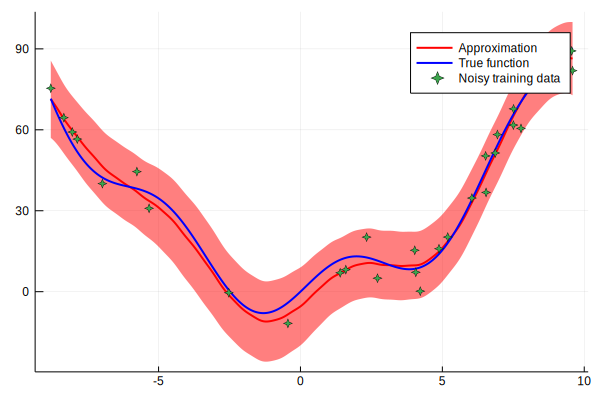

In [10]:
gpm = GPModel(training_x, training_y, SeIsoPeriodicKernel())
gp_train(gpm; log_level=1)
test_y, test_var = gp_regression(test_x, gpm)

plot(test_x, test_y, ribbon=1.96 * sqrt.(test_var), c=:red, linewidth=2, label="Approximation")
plot!(test_x, f.(test_x), c=:blue, linewidth=2, label="True function")
scatter!(training_x, training_y, m=:star4, label="Noisy training data")

Now, let's implement the gradient for the new kernel, as well as short cirquit functions for computing the covariance using cached computation results (`covariance_training`), and for diagonal-only variance (`covariance_diagonal`)

In [11]:
function update_cache(cache::SeIsoPeriodicKernelCache, log_theta::AbstractArray{Float64, 1}, x::AbstractArray{Float64, 2})
    sigma_f = exp(log_theta[1] * 2)
    sigma_g = exp(log_theta[3])
    D2 = scaled_squared_distance([log_theta[2]], x, x)
    n = size(x, 1)
    D = repeat(x, 1, n) - repeat(x', n, 1)
    cache.last_theta = copy(log_theta)
    cache.se_part = sigma_f .* exp.(-D2 ./ 2)
    cache.periodic_part = exp.(-2 .* (sin.(pi * sigma_g .* D).^2))
    cache.D2 = D2
    cache.D = D
    0
end

function covariance_grad(ker::SeIsoPeriodicKernel, log_theta::AbstractArray{Float64, 1}, 
        x::AbstractArray{Float64, 2}, R::AbstractArray{Float64, 2}) 
    cache = ker.cache
    if log_theta != cache.last_theta 
        update_cache(ker.cache, log_theta, x)
    end
    KR = cache.se_part .* R
    d1 = 2 * sum(KR)
    d2 = KR[:]' * cache.D2[:]
    sigma_g = exp(log_theta[3])
    periodic_arg = sigma_g .* pi .* cache.D
    d3 = sum(R' .* cache.periodic_part .* -2 .* sin.(2 .* periodic_arg) .* periodic_arg)
    return [d1, d2, d3]
end

function covariance_training(ker::SeIsoPeriodicKernel,
        log_theta::AbstractArray{Float64, 1}, x::AbstractArray{Float64, 2}) 
    if log_theta != ker.cache.last_theta
        update_cache(ker.cache, log_theta, x)
    end
    return ker.cache.periodic_part + ker.cache.se_part 
end
  
function covariance_diagonal(ker::SeIsoPeriodicKernel, log_theta::AbstractArray{Float64, 1}, x::AbstractArray{Float64, 2})
    fill(exp(log_theta[1] * 2) + 1, (size(x, 1), 1))
end

covariance_diagonal (generic function with 6 methods)

Now when we train the GP and run the regression, we can see that Conjugate Gradient Descent is used.

Bound optimisation using Optim.ConjugateGradient{Float64,Nothing,getfield(Optim, Symbol("##30#32")),LineSearches.InitialHagerZhang{Float64},LineSearches.HagerZhang{Float64,Base.RefValue{Bool}}}. Gradient provided. Start point: [1.0, 1.0, 1.0, 1.0]; lower bound: [-10.0, -10.0, -10.0, -10.0]; upper bound: [10.0, 10.0, 10.0, 10.0]
 * Status: success

 * Candidate solution
    Minimizer: [3.92e+00, 1.10e+00, 4.50e+00,  ...]
    Minimum:   1.137821e+02

 * Found with
    Algorithm:     Fminbox with Conjugate Gradient
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.09e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    5
    f(x) calls:    3714
    ∇f(x) calls:   2954

Optimized log hyperparameters: [3.92

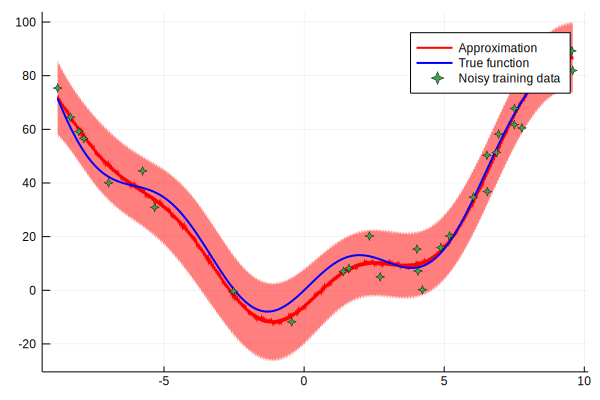

In [12]:
gpm = GPModel(training_x, training_y, SeIsoPeriodicKernel())
gp_train(gpm; log_level=1)
test_y, test_var = gp_regression(test_x, gpm)

plot(test_x, test_y, ribbon=1.96 * sqrt.(test_var), c=:red, linewidth=2, label="Approximation")
plot!(test_x, f.(test_x), c=:blue, linewidth=2, label="True function")
scatter!(training_x, training_y, m=:star4, label="Noisy training data")